<a href="https://colab.research.google.com/github/HKimura787/blog/blob/main/Qiita/SBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp
import pandas as pd
import seaborn as sns

(array([ 4., 18., 30., 30., 17., 22., 63., 57., 42., 17.]),
 array([-15.52989816,  -6.59376357,   2.34237102,  11.27850561,
         20.2146402 ,  29.1507748 ,  38.08690939,  47.02304398,
         55.95917857,  64.89531316,  73.83144775]),
 <BarContainer object of 10 artists>)

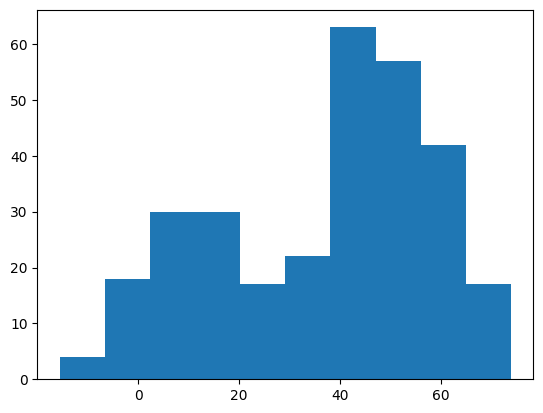

In [25]:
# 模擬データ
np.random.seed(0)
x1 = np.random.normal(10,10,100)
x2 = np.random.normal(50,10,200)
simulated_data = np.concatenate([x1,x2])
plt.hist(simulated_data)

In [26]:
# SBPモデル
class model_sbp(pm.Model):
    def __init__(self, data, n_max_comp):
        super().__init__()
        self.add_coord('comps',np.arange(n_max_comp))
        obs_data = pm.ConstantData('obs_data', data)

        # 各コンポーネントの重みパラメータ
        w_alpha = pm.Gamma("w_alpha", 1.0, 1.0)
        w = pm.StickBreakingWeights('w', alpha = w_alpha, K = n_max_comp-1,dims = 'comps')

        # N個の正規分布に順序を付けて識別可能にする
        a_mu = pm.Normal('a_mu', mu = 0, sigma = 10, dims = 'comps', transform = pm.distributions.transforms.ordered, initval = np.linspace(-10, 100, n_max_comp))
        a_sig = pm.Uniform('a_sig', lower = 0, upper = 100)
        comps = pm.Normal.dist(mu = a_mu, sigma = a_sig)

        # 混合正規分布
        obs = pm.Mixture('obs', w = w, comp_dists = comps, observed = obs_data)

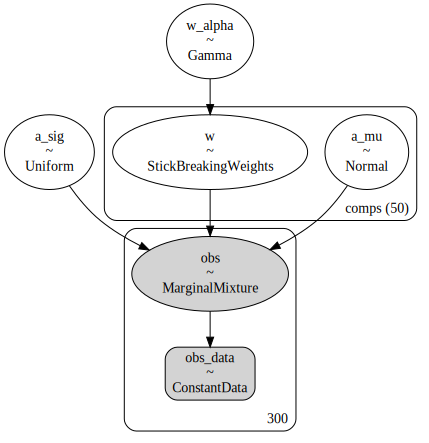

In [27]:
mod = model_sbp(simulated_data, 50)
pm.model_to_graphviz(mod)

In [49]:
idata = pm.sample(model = mod, random_seed = 1, target_accept = 0.8)

In [58]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_alpha,32.606,4.658,23.844,41.046,0.076,0.054,3711.0,1379.0,1.0
w[0],0.004,0.004,0.000,0.010,0.000,0.000,2349.0,966.0,1.0
w[1],0.004,0.004,0.000,0.012,0.000,0.000,1874.0,788.0,1.0
w[2],0.004,0.004,0.000,0.012,0.000,0.000,2885.0,1143.0,1.0
w[3],0.005,0.005,0.000,0.013,0.000,0.000,1932.0,977.0,1.0
...,...,...,...,...,...,...,...,...,...
a_mu[46],19.810,2.679,14.619,24.576,0.053,0.038,2611.0,1742.0,1.0
a_mu[47],21.981,3.146,16.327,27.969,0.062,0.044,2703.0,1814.0,1.0
a_mu[48],25.807,4.604,17.710,34.537,0.145,0.112,1290.0,792.0,1.0
a_mu[49],49.921,0.789,48.418,51.378,0.017,0.012,2089.0,944.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


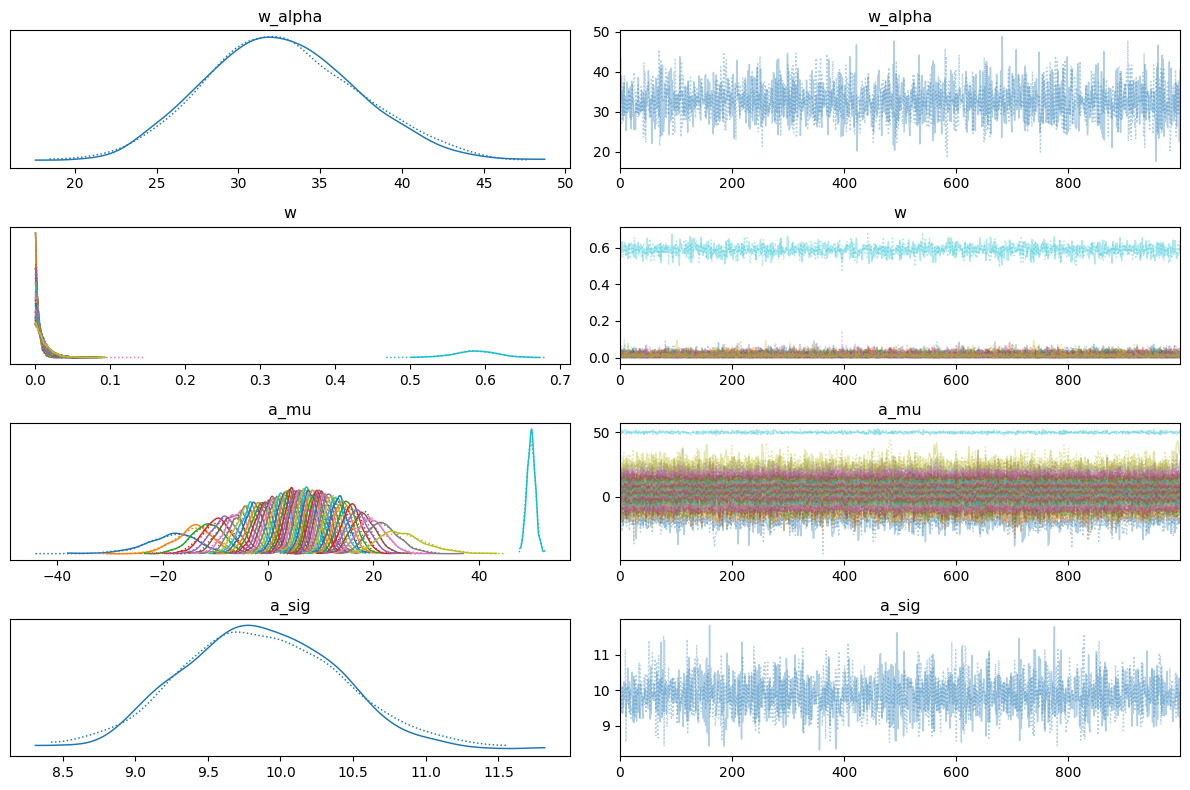

In [52]:
az.plot_trace(idata)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

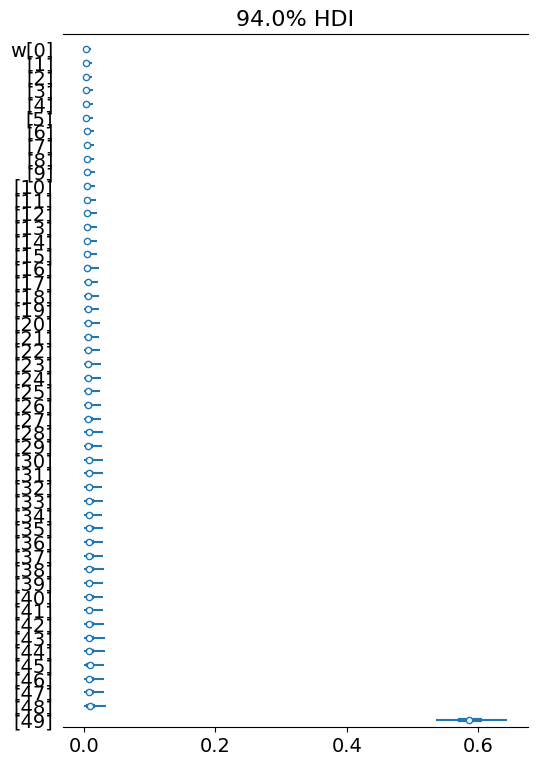

In [53]:
az.plot_forest(idata, var_names="w", combined=True)

In [55]:
# 結果図示用データの生成

# X軸用のデータを生成
x_plot = xr.DataArray(np.arange(np.min(simulated_data), np.max(simulated_data),step=0.1), dims=["plot"])
# 事後分布から確率密度を計算
post_pdf_contribs = xr.apply_ufunc(sp.stats.norm.pdf, x_plot, idata.posterior["a_mu"], idata.posterior["a_sig"])
# 重みの事後分布で確率密度を調整
post_pdfs = (idata.posterior["w"] * post_pdf_contribs).sum(dim=("comps"))
# 95%信用区間の上限と下限を計算
# post_pdf_quantiles = post_pdfs.quantile([0.025, 0.975], dim=("chain", "draw"))

# 模擬データをデータフレームに変換
data_df = pd.DataFrame({'simulated_data':simulated_data})

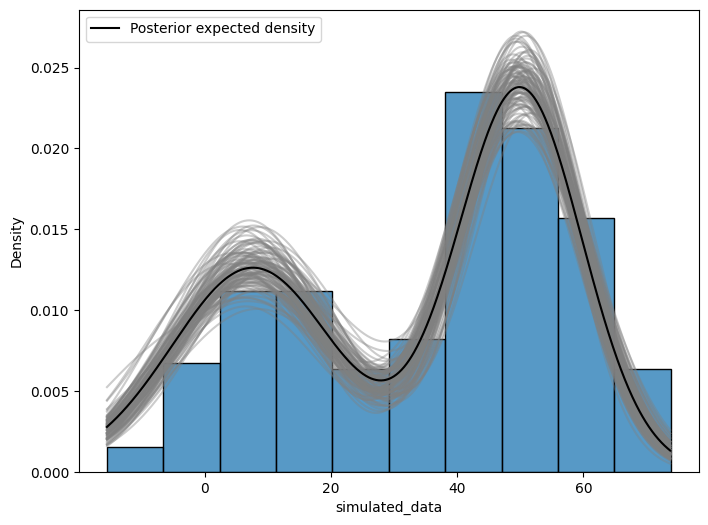

In [56]:
# 図示
fig, ax = plt.subplots(figsize=(8, 6))
# サンプルから100個抽出して確率密度をプロット
ax.plot(x_plot, az.extract(post_pdfs, var_names="x", num_samples=100), c="gray", alpha=0.4)
# 平均事後確率密度をプロット
ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
# データをヒストグラムとしてプロット
sns.histplot(x='simulated_data',ax=ax,data=data_df,stat="density")
ax.legend()
plt.show()